In [1]:
import numpy as np
import pandas as pd
import pyodbc
import sqlalchemy
import sqlite3
from subprocess import check_output
import os
from IPython.core.display import Image, display

from sqlalchemy import create_engine
engine = create_engine('sqlite:////...', echo=False)

# PRACTICEs
Get ready to work with views! In this chapter_kernel, you will learn how to create and query views. On top of that, you'll master more advanced capabilities to manage them and end by identifying the difference between `materialized` and `non-materialized` views.

## 1. Database views
In a database, a `view` is a result set of stored query on the data, which the database users can query just as they would in the persistent database collection object [Wikipeida]
#### Virtual table that is not part of physical schema
> Query, not data, is stored in the memory

> Data is aggregate from the data in table

> Can be queried like a regular database in table

> No needs to retype the common queries or alter schemas.

#### Creating a view (syntax)

        SELECT column_name_1, col_name_2
        FROM table_name
        WHERE condition_or_criteria

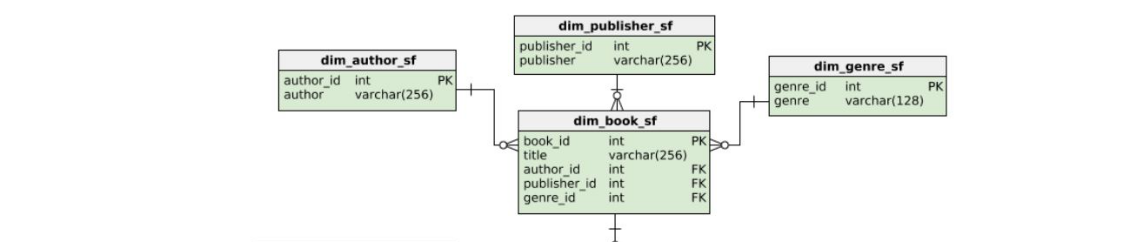

In [2]:
## For example
## GOAL : Returns titles & authors of the science_fiction genre
## hidden code

#### Example 1.2 (creating a view)

    CREATE VIEW scifi_books AS(
                                SELECT title, author, genre
                                FROM dim_book_sf
                                JOIN dim_genre_sf ON dim_genre_sf.genre_id = dim_book_sf.genre_id
                                JOIN dim_author_sf ON dim_author_sf.author_id = dim_book_sf.genre_id
                                WHERE dim_genre_sf.genre = 'science fiction'
                                );
    SELECT * FROM scifi_books;
**query result**              

| title | author | genre |
|-------|--------|-------|
| The Naked Sun | Issac Asimov | science_fiction |
| The Robot of Dawn | Issac Asimov | science_fiction |
| The Time Machine | H.G. Wells | science_fiction |
| The Invisible Man| H.G. Wells | science_fiction |
| The War of the Worlds| H.G. Wells | science_fiction |
| Wild Seed (Patternmaster, #1)| Octivia E. Bulter| science_fiction |
| ... | ... | ... |

**BEHIND THE SCENCES.**
Noting that the syntax

            SELECT * FROM scifi_books
is equivalent to
    
            SELECT * FROM (SELECT title, author, genre
                            FROM dim_book_sf
                                JOIN dim_genre_sf ON dim_genre_sf.genre_id = dim_book_sf.genre_id
                                JOIN dim_author_sf ON dim_author_sf.author_id = dim_book_sf.genre_id
                            WHERE dim_genre_sf.genre = 'science fiction');

### Viewing views!
#### In PostgreSQL.
For example,

        SELECT * FROM INFORMATION_SCHEMA.views;
includes system views
        
        SELECT * FROM information_schema.views
        WHERE table_schema NOT IN ('pg_catalog', 'information_schema')
excludes system views.

#### Benifits of views
> Doesn't take up storage

> A form of **access control**. Hide sensity columns and restrict what user can see.

> Masks complexity of the queries. Useful for highly normalized schemas

### EXERCISEs

#### Exercise 1.1. Tables vs. views
Views have been described as "virtual tables". It's true that views are similar to tables in certain aspects, but there are key differences. In this exercise, you will organize these differences and similarities.

Organize these characteristics into the category that they describe best.

**SOLUTION.**

     |==============================|==============================|==============================|
     |          Only table          |        Views & tables        |          Only views          |
     |------------------------------*------------------------------*------------------------------|
     |  Part of the physical schema |   Contains rows & columns    |   Always defined by a query  |
     | of database                  |
     |..............................*..............................*..............................|
     |                              |   Can be queried             |   Takes up less memory       |
     |..............................*..............................*..............................|
     |                              |   Has access control         |                              |
     |..............................*..............................*..............................|
     
**Comment!**  It looks like you got the hang of tables and views. These characteristics can help make decisions about what needs to be a table or view.

#### Exercise 1.2. Viewing views
Because views are very useful, it's common to end up with many of them in your database. It's important to keep track of them so that database users know what is available to them.

The goal of this exercise is to get familiar with viewing views within a database and interpreting their purpose. This is a skill needed when writing database documentation or organizing views.

#### Instructions 
**Step 1.** Query the information schema to get views. Then exclude system views in the results.

**SOLUTION.**

                -- Get all non-systems views
                SELECT * FROM information_schema.views
                WHERE table_schema NOT IN ('pg_catalog', 'information_schema');
**query result.**

table_catalog|table_schema|table_name|view_definition|check_option|is_updatable|is_insertable_into|is_trigger_updatable|is_trigger_deletable|is_trigger_insertable_into
-------------|------------|----------|---------------|------------|------------|------------------|--------------------|--------------------|---------------------------
dataarchpost|public|view1| SELECT content.reviewid, content.content FROM content WHERE (length(content.content) > 4000);|NONE|YES|YES|NO|NO|NO
dataarchpost|public|view2| SELECT reviews.reviewid, reviews.title, reviews.score FROM reviews WHERE (reviews.pub_year = 2017) ORDER BY reviews.score DESC LIMIT 10;|NONE|NO|NO|NO|NO|NO

**Step 2. Answer this question.** What does view1 do?

A. Returns the content records with `reviewids` that have been viewed more than 4000 times.

B. Returns the content records that have `reviews of` more than 4000 characters.

C. Returns the first 4000 records in `content`.

**Answers & comments.**

Look at the `view_definition`:

                SELECT content.reviewid, content.content 
                FROM content 
                WHERE (length(content.content) > 4000)
So, we have

*A. Wrong!* The `content` table doesn't have a field to count views of a review (just `content.reviewid` and `content.content`).

**B. Correct!!!** Since we have a condition `WHERE (length(content.content) > 4000)`.

*C. Wrong!* There's no **`LIMIT 4000`** statement in the view definition.

**Step 3. Answer this question!** What does `view2` do?

A. Returns 10 random reviews published in 2017.

B. Returns the top 10 lowest scored reviews published in 2017.

C. Returns the top 10 highest scored reviews published in 2017.

**Answers & comments.** Again, look back the `view_definition` of `view2`, 

            SELECT reviews.reviewid, reviews.title, reviews.score
            FROM reviews
            WHERE (reviews.pub_year = 2017)
            ORDER BY reviews.score DESC
            LIMIT 10;	

*A. Wrong!!* Focus on the **`ORDER BY`** statement!

*B. Incorrect!!* Since the **`DESC`** modifier in the **`ORDER BY`** statement.

**C. Correct!!!**

==> Note that unlike this exercise, you should always give views descriptive names for views!

#### Exercise 1.3. Creating and querying a view
Have you ever found yourself running the same query over and over again? Maybe, you used to keep a text copy of the query in your desktop notes app, but that was all before you knew about views!

In these `Pitchfork reviews`, we're particularly interested in high-scoring reviews and if there's a common thread between the works that get high scores. 

In this exercise, you'll make a view to help with this analysis so that we don't have to type out the same query often to get these high-scoring reviews.

**`reviews` table (just the first 3 lines)**

reviewid|title|url|score|best_new_music|author|author_type|pub_date|pub_weekday|pub_day|pub_month|pub_year
--------|-----|---|-----|--------------|------|-----------|--------|-----------|-------|---------|--------
22703|mezzanine|http://pitchfork.com/reviews/albums/22703-mezzanine/|9.3|0|nate patrin|contributor|2017-01-08|6|8|1|2017
22721|prelapsarian|http://pitchfork.com/reviews/albums/22721-prelapsarian/|7.9|0|zoe camp|contributor|2017-01-07|5|7|1|2017
22659|all of them naturals|http://pitchfork.com/reviews/albums/22659-all-of-them-naturals/|7.3|0|david glickman|contributor|2017-01-07|5|7|1|2017


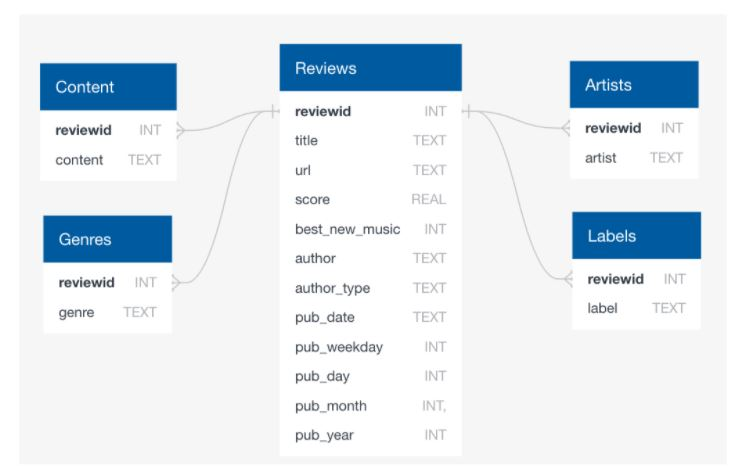

In [5]:
## hidden

#### Instructions
**Step 1.** Create a view called `high_scores` that holds reviews with `scores` above a 9.

**SOLUTION.**

                -- Create a view for reviews with a score above 9
                CREATE VIEW high_scores AS (
                                            SELECT * FROM reviews
                                            WHERE score > 9; )

**Step 2.** Count the number of records in `high_scores` that are `self-released` in the `label` field of the `labels` table.

**SOLUTION.**

            CREATE VIEW high_scores AS
            SELECT * FROM REVIEWS
            WHERE score > 9;

            -- Count the number of self-released works in high_scores
            SELECT COUNT(*) FROM high_scores
            INNER JOIN labels ON labels.reviewid = high_scores.reviewid
            WHERE label = 'self-released';
**query result.**

| count |
|-------|
| 3 |

Nice, you've just created and queried a view! It wasn't too hard, right? Views are great because they're easy to set up and use immediately thereafter.

## 2. Managing views

### Creating more complex views

| **Aggregation.** | **Joins** | **Conditionals** |
|-|-|-|
| `SUM(), AVG(), COUNT(), MIN(), MAX(), GROUP BY, etc.`| `INNER JOIN, LEFT JOIN, RIGHT JOIN, FULL JOIN` | `WHERE, HAVING, UNIQUE, NOT NULL, AND, OR, <, >=, etc` |

#### 2.1. Ranking & revoking access to a view.
**Syntax**

`GRANT privilege(s)` or `REVOKE privilege(s)`

`ON` object

`TO` role `FROM` role

**Explains.**
> **`Privilege(s)`:** `SELECT, INSERT, UPDATE, DELETE, etc.`

> **`Object`:** `table, view, schema`

> **`Roles` :** a database user or a group of database users

**Example.**
1) Using `Grant`

        GRANT UPDATE 
        ON ratings 
        TO PUBLIC;
        
2) Using `Revoke`

        REVOKE INSERT
        ON films
        FROM db_users

#### 2.2. UPDATING A VIEW,
For example,

        UPDATE films SET kind = 'Dramatic' WHERE kind = 'Drama'
then **not all views are updatable**. 

Noting that,
> **View** is made up of one table.

> Doesn't use a **window** or an **aggregate function**.

#### 2.3. INSERTING INTO A VIEW,
For example,

        INSERT INTO films (code, title, id, date_prod, kind)
                VALUES ('T-601', 'Yojimbo', 106, '1961-06-16', 'Drama')
then, **not all views are insertable**

==> **Advoid modifying data though views**

#### 2.4. DROPPING A VIEW
**`Syntax`:**

            DROP VIEW view_name [CASCADE | RESTRICT]
**Explains & comments.**
> **default = `RESTRICT`:** returns an error if there are objects that depend on the view

> **use `CASCADE` :** drop views and any object that depends on that view.

#### 2.5. REDEFINING A VIEW.
**`Syntax` :**

            CREATE OR REPLACE VIEW view_name AS new_query
**Comments**    
> If a view with `view_name` exists, it is replaced.

> `new query` must generate the same column names, orders and data types as the old query.

> The column output may be different.

> New columns may be added at the end.

==> **If these criteria can't be met, drop the existing view and create the new one!**

#### 2.6. ALTERING A VIEW.
For example,

        ALTER VIEW [IF EXISTS] name ALTER [column] column_name SET DEFAULT expression
        ALTER VIEW [IF EXISTS] name ALTER [column] column_name DROP DEFAULT
        ALTER VIEW [IF EXISTS] name OWNER TO new_owner
        ALTER VIEW [IF EXISTS] name RENAME TO new_name
        ALTER VIEW [IF EXISTS] name SET SCHEMA new_schema
        ALTER VIEW [IF EXISTS] name SET (view_option_name = [view_option_value] [, ...])
        ALTER VIEW [IF EXISTS] name RESET (view_option_name [, ...] )

### EXERCISEs

#### Exercise 2.1. Creating a view from other views
Views can be created from queries that include other views. This is useful when you have a complex schema, potentially due to normalization, because it helps reduce the **`JOINS`** needed. The biggest concern is keeping track of dependencies, specifically how any modifying or dropping of a view may affect other views.

In the next few exercises, we'll continue using the Pitchfork reviews data. There are two views of interest in this exercise. `top_15_2017` holds the top 15 highest scored reviews published in 2017 with columns `reviewid,title`, and `score`. 

`artist_title` returns a list of all reviewed titles and their respective artists with columns `reviewid, title`, and `artist`. 

From these views, we want to create a new view that gets the highest scoring artists of 2017.

**table: `artist_title`**

reviewid|title|artist
--------|-----|------
22703|mezzanine|massive attack
22721|prelapsarian|krallice
22659|all of them naturals|uranium club

**table `top_15_2017`**

reviewid|title|score
--------|-----|-----
22703|mezzanine|9.3
22661|first songs|9
22745|run the jewels 3|8.6

#### Instructions 
**Step 1.** Create a view called `top_artists_2017` with one column artist holding the top artists in 2017. 

Join the views `top_15_2017` and `artist_title`.

Then print out `top_artists_2017`.

**SOLUTION**

        CREATE VIEW top_artists_2017 AS
        -- with only one column holding the artist field
        SELECT artist_title.artist FROM artist_title
        INNER JOIN top_15_2017
        ON artist_title.reviewid = top_15_2017.reviewid;

        -- Output the new view
        SELECT * FROM top_artists_2017;
**query result.**

|artist
|--------
massive attack
krallice
uranium club
liliput
kleenex
taso
various artists
little simz
yotam avni
brian eno
harry bertoia
run the jewels
steven warwick
pete rock
smoke dza
various artists
senyawa

**Step 2. Answers this question!** Which is the **`DROP`** command that would drop both `top_15_2017` and `top_artists_2017`?

A. `DROP VIEW top_15_2017 CASCADE;`

B. `DROP VIEW top_15_2017 RESTRICT;`

C. `DROP VIEW top_artists_2017 RESTRICT;`

D. `DROP VIEW top_artists_2017 CASCADE;`

**Answers & comments.**

**A. Correct!!!** Because `top_artists_2017` depends on `top_15_2017`, the **`CASCADE`** `parameter` indicates both should be dropped.

*B. Wrong!!* Remember that **`RESTRICT`** doesn't drop the view if other view(s) depends on it.

*C. Incorrect!!* This statement would just drop `top_artists_2017`.

*D. Wrong!!* This statement would have no effect on `top_15_2017` because there is not dependency in this direction.

#### Exercise 2.2. Granting and revoking access
Access control is a key aspect of database management. Not all database users have the same needs and goals, from analysts, clerks, data scientists, to data engineers. As a general rule of thumb, write access should never be the default and only be given when necessary.

In the case of our Pitchfork reviews, we don't want all database users to be able to write into the `long_reviews view`. 

Instead, the editor should be the only user able to edit this view.

**table : `long_reviews` (the first 3 lines)**

reviewid|content
--------|-------
22703|Trip-hop eventually became a ’90s punchline, a music-press shorthand for overhyped hotel lounge music. But today, the much-maligned subgenre almost feels like a secret precedent. Listen to any of the canonical Bristol-scene albums of the mid-late ’90s, when the genre was starting to chafe against its boundaries, and you’d think the claustrophobic, anxious 21st century started a few years ahead of schedule. Looked at from the right angle, trip-hop is part of an unbroken chain that runs from the abrasion of ’80s post-punk to the ruminative pop-R&B-dance fusion of the moment. The best of it has aged far more gracefully (and forcefully) than anything recorded in the waning days of the record industry’s pre-filesharing monomania has any right to. Tricky rebelled against being attached at the hip to a scene he was already looking to shed and decamped for Jamaica to record a more aggressive, bristling-energy mutation of his style in ’96; the name Pre-Millennium Tension is the only obvious thing that tells you it’s two decades old rather than two weeks. And Portishead’s ’97 self-titled saw the stress-fractured voice of Beth Gibbons envisioning romance as codependent, mutually assured destruction while Geoff Barrow sunk into his RZA-noir beats like The Conversation’s Gene Hackman ruminating over his surveillance tapes. This was raw-nerved music, too single-minded and intense to carry an obvious timestamp. But Massive Attack were the origin point of the trip-hop movement they and their peers were striving to escape the orbit of, and they nearly tore themselves to shreds in the process. Instead— or maybe as a result—they laid down their going-nova genre's definitive paranoia statement with Mezzanine. The band's third album (not counting the Mad Professor-remixed No Protection) completes the last in a sort of de facto Bristol trilogy, where Tricky’s youthful iconoclasm and Portishead’s deep-focus emotional intensity set the scene for Massive Attack’s sense of near-suffocating dread. The album corroded their tendencies to make big-wheel hymnals of interconnected lives where hope and despair trade precedent—on Mezzanine, it’s alienation all the way down. There’s no safety from harm here, nothing you’ve got to be thankful for, nobody to take the force of the blow: what Mezzanine provides instead is a succession of parties and relationships and panopticons where the walls won’t stop closing in.The lyrics establish this atmosphere all on their own. Sex, in Inertia Creeps, is reduced to a meeting of two undernourished egos, four rotating hips, the focus of a failing relationship that's left its participants too numbed with their own routine dishonesty to break it off. The voice singing it—Massive Attack's cornerstone co-writer/producer Robert 3D Del Naja—is raspy from exhaustion. Dissolved Girl reiterates this theme from the perspective of guest vocalist Sarah Jay Hawley (Passion’s overrated anyway). On Risingson, Grant Daddy G Marshall nails the boredom and anxiety of being stuck somewhere you can’t stand with someone you’re starting to feel the same way about (Why you want to take me to this party and breathe/I’m dying to leave/Every time we grind you know we severed lines). But Mezzanine’s defining moments come from guest vocalists who were famous long before Massive Attack even released their first album. Horace Andy was already a legend in reggae circles, but his collaborations with Massive Attack gave him a wider crossover exposure, and all three of his appearances on Mezzanine are homages or nods to songs he'd charted with in his early-’70s come-up. Angel is a loose rewrite of his 1973 single You Are My Angel, but it’s a fakeout after the first verse—originally a vision of beauty (Come from way above/To bring me love), transformed into an Old Testament avenger: On the dark side/Neutralize every man in sight. The parenthetically titled, album-closing reprise of (Exchange) is a ghostly invocation of Andy’s See A Man's Face cleverly disguised as a comedown track. And then there’s Man Next Door, the John Holt standard that Andy had previously recorded as Quiet Place—on Mezzanine, it sounds less like an overheard argument from the next apartment over and more like a close-quarters reckoning with violence heard through thin walls ready to break. It’s Andy at his emotionally nuanced and evocative best.The other outside vocalist was even more of a coup: Liz Fraser, the singer and songwriter of Cocteau Twins, lends her virtuoso soprano to three songs that feel like exorcisms of the personal strife accompanying her band’s breakup. Her voice serves as an ethereal counterpoint to speaker-rattling production around it. Black Milk contains the album’s most spiritually unnerving words (Eat me/In the space/Within my heart/Love you for God/Love you for the Mother), even as her lead and the elegiac beat make for some of its most beautiful sounds. She provides the wistful counterpoint to the night-shift alienation of Group Four. And then there's Teardrop, her finest moment on the album. Legend has it the song was briefly considered for Madonna; Andrew Mushroom Vowles sent the demo to her, but was overruled by Daddy G and 3D, who both wanted Fraser. Democracy thankfully worked this time around, as Fraser’s performance—recorded in part on the day she discovered that Jeff Buckley, who she’d had an estranged working relationship and friendship with, had drowned in Memphis’ Wolf River—was a heart-rending performance that gave Massive Attack their first (and so far only) UK Top 10 hit.Originally set for a late ’97 release, Mezzanine got pushed back four months because Del Naja refused to stop reworking the tracks, tearing them apart and rebuilding them until they’re so polished they gleam. It sure sounds like the product of bloody-knuckled labor, all that empty-space reverb and melted-together multitrack vocals and oppressive low-end. (The first sound you hear on the album, that lead-jointed bassline on Angel, is to subwoofers what Planet Earth is to high-def television.) But it also groans with the burden of creative conflict, a working process that created rifts between Del Naja and Vowles, who left shortly after Mezzanine dropped following nearly 15 years of collaboration.Mezzanine began the band’s relationship with producer Neil Davidge, who’d known Vowles dating back to the early ’90s and met the rest of the band after the completion of Protection. He picked a chaotic time to jump in, but Davidge and 3D forged a creative bond working through that pressure. Mezzanine was a document of unity, not fragmentation. Despite their rifts, they were a post-genre outfit, one that couldn’t separate dub from punk from hip-hop from R&B because the basslines all worked together and because classifications are for toe tags. All their acknowledged samples—including the joy-buzzer synths from Ultravox’s Rockwrok (Inertia Creeps), the opulent ache of Isaac Hayes’ celestial-soul take on Our Day Will Come (Exchange), Robert Smith’s nervous tick tick tick from the Cure’s 10:15 Saturday Night, and the most concrete-crumbling throwdown of the Led Zep Levee break ever deployed (the latter two on Man Next Door)—were sourced from  1968 and 1978, well-traveled crate-digging territory. But what they build from that is its own beast.  Their working method never got any faster. The four-year gap between Protection and Mezzanine became a five-year gap until 2003’s 100th Window, then another seven years between that record and 2010’s Heligoland, plus another seven years and counting with no full-lengths to show for it. Not that they've been slacking: we've gotten a multimedia film/music collaboration with Adam Curtis, the respectable but underrated Ritual Spirit EP, and Del Naja’s notoriously rumored side gig as Banksy. (Hey, 3D does have a background in graffiti art.) But the ordeal of both recording and touring Mezzanine took its own toll. A late ’98 interview with Del Naja saw him optimistic about its reputation-shedding style: I always said it was for the greater good of the fucking project because if this album was a bit different from the last two, the next one would be even freer to be whatever it wants to be. But fatigue and restlessness rarely make for a productive mixture, and that same spark of tension which carried Mezzanine over the threshold proved unsustainable, not just for Massive Attack’s creativity but their continued existence.Still, it’s hard not to feel the album’s legacy resonating elsewhere—and not just in Teardrop becoming the cue for millions of TV viewers to brace themselves for Hugh Laurie’s cranky-genius-doctor schtick. Graft its tense feelings of nervy isolation and late-night melancholy onto two-step, and you’re partway to the blueprint for Plastician and Burial. You can hear flashes of that mournful romantic alienation in James Blake, the graceful, bass-riddled emotional abrasion in FKA twigs, the all-absorbing post-genre rock/soul ambitions in Young Fathers or Algiers. Mezzanine stands as an album built around echoes of the ’70s, wrestled through the immediacy of its creators' tumultuous late ’90s, and fearless enough that it still sounds like it belongs in whatever timeframe you're playing it.
22661|Kleenex began with a crash. It transpired one night not long after they’d formed, in Zurich of 1978, while the germinal punk group was onstage. They had but four tunes then—Beri-Beri, Ain’t You, Heidi’s Head, Nice—and at early gigs they would play them over and over to small but delighted crowds who did not want the noise to stop. When Kleenex’s original male guitarist didn’t care to continue on as such, the late Marlene Marder stepped up from the audience and swiftly found her place alongside bassist Klaudia Schifferle and drummer Lislot Ha. Marder—a literal post-punk; she delivered mail—was armed with a knowledge of two chords if not an awareness of pitch. Lislot didn’t know that you can tune a drum kit, Marder once said. We played like this for a year, without tuned drum kits or a tuned bass or guitar. The guys were more ambitious so they didn’t want to play with us. For us, it was OK not because we said, ‘We’re the greatest!’ We just did as we could. Not serious in the beginning.In all their chaos, those four songs were unusually taut. Kleenex made riotous music like a rubber band; it could tighten, or snap, or shoot in air. When some friends in the small Swiss punk scene released them as the Kleenex EP, word moved fast. The exuberant 45 made its way quickly to Britain, entering the orbit of John Peel as well as the Marxist intellectuals at the then-nascent Rough Trade label, beginning Kleenex’s affiliation with that bohemian London scene. Ain’t You—with its wiry riffs and chanted, pogoing hooks, its chic edge and abandon—fit well on Rough Trade’s 1980 Wanna Buy a Bridge? comp, alongside the scratchy Swell Maps and their similarly daring one-time tour mates, the Raincoats. First Songs collects Kleenex’s output from ’78 to 1982, preceding their first album (at which point they’d been forced by the tissue company to switch their perfect name—capturing the very Pop disposability of consumer culture—to LiLiPUT). The band’s lineup was constantly in flux; these songs also feature saxophonist Angie Barrack and vocalists Regula Sing and Chrigle Freund. The reissue’s title is clever; if these 24 tracks are all indeed songs, then Kleenex was reimagining what a song could be. The shortest one, the 69-second 1978, for example, is a queasy interstitial propelled by unsparing riffs and amusingly primordial drumming. On Eisiger Wind (Icy Wind), the clangor and OOO AHHHs and LA LA LA LAs culminate with a nails-tough 15-second coda that brings to mind Mothers of Invention. But then, in Kleenex’s gleefully anarchic world, song structures seemed tedious.Their methods of composition were peculiar even for punk. One was extreme repetition, in which a song would progress by repeating a few minimal bars over and over, starting slowly and speeding up each time, as if running up a hill and then tumbling down it. The band punctuated their music with things like whistling and saxophones and kazoo sounds. Their guitar chords had a soured edge, and their lopsided call-and-response vocals alternately evoked stoic Patti Smith and a wayward school choir. Most crucial were the befuddlingly shredded human voices—grunted, exasperated, bloodcurdlingly shrieked, pitched so high as to pierce into the reddest red—which sounded more like a Yoko Ono Fluxus experiment than anything resembling pop. But the inquisitive core of Kleenex’s music stokes curiosity in a listener: From what plane of existence does that scream originate? Is that a person? Is that a recorder? What even is a nighttoad?The lyrics, sung in English and Swiss-German, veer between ominous images or deliberate nonsense. On Die Matrosen (The Sailors), the song’s jovial whistling is undermined by a narrative of a man in a pub who had a blackout and lost control. The combination of a grave voice with sugary ones on Beri-Beri skewers the lyric and each day you feel nicer! Madness is one of the most affecting Kleenex songs, with its alternately slammed and melancholy chords: Hey madness you have touched me, it goes, Hey madness what do you want from me? These emphatic early songs are fervent invocations, evidence that pure conviction could summon magic and newness from the wilderness within.The signature Kleenex songs fall together in ways that manage to approximate pop. The best one is Hitch Hike. Girl was on the road to drive away/She had no money to pay the train, goes the gummy, sing-song chorus. Hitch hike ghost, don’t touch me/...Let me be. Upbeat as Hitch Hike feels, it also touches on the necessary guardedness of being a woman in public, the adventure and risk of the female wanderer (it reminds me of Cindy Sherman’s 1979 Untitled Film Still #48). Defiant beyond its jingly form, it’s cut with the howls of a rape whistle. Not unlike their comrades in the Raincoats, Kleenex’s collective shouts were eruptions of joy as well as gestures of outsider solidarity.At the heart of Kleenex’s music is a radical sense of resourcefulness. It’s part of what helps them transcend their moment; indeed, many of the works of artier O.G. punk bands feel more potent today than those of their instigating major-label peers. Accordingly, the decimating screams of Ü—EEEEEEEEEEEE—are the point of punk (it’s worth noting that Greil Marcus put Ü on his influential Lipstick Traces compilation). Kleenex collaborated with Rough Trade’s early go-to production duo of Geoff Travis and Red Krayola’s Mayo Thompson on the Ü/You single, perhaps owing to its audacious and wildly electric ensemble feel. You explodes with democratic purpose: This is your life/This is your day/It’s all for you. With that, the influence of Kleenex on a punk scene like Olympia’s from the 1980s onward is palpable; Kurt Cobain included anything by Kleenex on his list of favorite albums, but Bikini Kill’s Liar or Girlpool’s Jane are primary sources for the legacy of Kleenex screams today. Split is the perfect storm of Kleenex’s bottle-rocket inventiveness. The lyrics go, Hotch-potch, hugger-mugger, bow-wow, hara-kiri, hoo-poo, huzza, hicc-up, hum-drum, hexa-pod, hell-cat, helter-skelter, hop-scotch. This dizzied, scissor-cut, full-throttle collage is undercut with spirited declarations that, Yesterday was a party! Yesterday the drinks were strong! and a crude siren of woo! woo! woo! woo!s. There is nothing cerebral; there is only pure jubilance, only action. Split doesn’t sound sung as much as it sounds like it’s bolting out of someone’s chest. Play Split alongside anything off Never Mind the Bollocks and see which sounds more lawless; Kleenex make Sex Pistols sound like alt-rock.We didn't have songs like ‘Fuck the System’ like other bands had, Marder once said. We didn’t throw stones and smash windows. We stood there and played songs. But an autonomous message persisted. For several months in 1980, violent youth riots turned Zurich into a war zone, sparked by a paucity of funding and space for the alternative arts scene. Kleenex responded viscerally to this unwelcoming world by creating their own.In 2017, the rollercoaster ride of punk remains replete with adrenaline and adventure and thrills, with semblances of danger and truth. But rollercoasters have tracks and belts and guards; they are always the same. Kleenex built a rollercoaster with loose bolts, not at all predictable, bravely betraying structure, careening. At its best, punk offers up a self-immolating blueprint that says, year after year, the blueprint is yet to be written. Kleenex’s raw rapture still lights up this idea. First Songs is a testament to the freedom in limitation, or rather, the limitless nature of freedom when logic is tossed aside.
22722|In the pilot episode of Insecure, the critically lauded HBO comedy series created by Issa Rae and Larry Wilmore, Rae’s eponymous character Issa is at a crossroads. She’s in a stable but stale relationship, and the occasion of her 29th birthday has her wondering if she’s wasting time on a romance that’s heading nowhere. Issa decides to take her best friend Molly, who’s also feeling unlucky in love after a streak of failed flings, to an open mic night in hopes of setting her up with someone new—but secretly to reconnect with an ex-boyfriend. Before long, egged on by said ex, Issa winds up on the stage rapping about Broken Pussy, a term that she coined to explain Molly’s recent poor run of form (Maybe it’s really rough, maybe it’s had enough.)The resulting cheesy freestyle, set to the tune of Kelis’ twinkly 2006 hit Bossy, makes the cut as the second song on Insecure (Music From the HBO Original Series). Its placement injects a welcome dose of Issa’s personality (both fictional and real—Rae wrote the song with Wilmore) into the soundtrack, while acting as the skeleton key to understanding the rest of the selection; back on the small screen, Broken Pussy costs Molly the attention of a potential love interest and leads to a big fight between the two, but they reconcile easily by the end of the episode. The show Insecure excels at tracing the professional and affective tribulations of young black adults in L.A., but it stands apart for its depiction of the unbreakable black female friendship at the heart of the story. Insecure (Music from the HBO Original Series) celebrates this dynamic with 16 songs: mostly by or about women, almost exclusively by black artists. Arkansas-native Kari Faux kicks things off with No Small Talk, an anthem for the self-possessed, recorded previously for her 2014 EP Laugh Now, Die Later. A ringing phone blends in with a hard-hitting drum pattern to buoy Faux’s cool-but-confident delivery, replete with nods to Pimp C and 2 Chainz: Three cellphones and I still don’t ever text ‘em/Catch me out in public and you know I’m flexin’. Faux makes another appearance on Top Down assisted by Brooklyn MC Leikeli47, whose cadence recalls that of fellow New Yorker Amil. The song, a bouncy electropop composition about riding around in a drop top feeling like a million bucks, was commissioned for the first season finale.Much of the soundtrack appeared across Insecure’s 8 episodes to date, curated by the show’s eminent musical consultant Solange Knowles, who knows a thing or two about elucidating the black female experience on wax to dazzling effect. The feel-good anthems give way to songs that address a range of romantic entanglements. Girl, a standout track from the Internet’s 2015 album Ego Death, is expertly reimagined as an electric-guitar-driven ode to the feminine by SoCal ensemble 1500 or Nothin. Guordan Banks switches between the high and low register over a slick bassline on Keep You in Mind, a call for moving past the coy stages of flirtation onto something more serious.Although Faux’s Top Down is the only original song on Insecure, the rest were chosen carefully to illuminate the main characters’ tastes and animate the world that they inhabit, situated for the most part in predominantly black South L.A. neighborhoods like Leimert Park and Baldwin Hills. This is achieved by featuring either the work of local artists, like the 1500 or the Internet themselves (Just Sayin/I Tried), or songs that evoke a similar sense of place, like the sunny strings of Palm Trees by D.C. rapper GoldLink.Considered independently from the influences of the show, the Insecure soundtrack works as a seamless collection of hip-hop, soul and R&B. The list of performers runs the gamut from established artists like D’Angelo (Sugah Daddy) and Thundercat (Heartbreaks + Setbacks) to emerging talents like TT the Artist (Lavish) and Banks, who claimed his first Billboard #1 with Keep You in Mind last summer. In recent months, the well-timed placement of a song in a new TV series has taken on renewed importance as a means for new artists to raise their profile. Insecure was already renewed for a second season and while the protagonists’ fate is surely the highest priority for fans, a chance to devour the forthcoming score can’t be too far behind.
22714|Ambient music is a funny thing. As innocuous as it may seem on the surface, it can often be seen as an intrusion, an irritant. Muzak annoyed as many people as it mellowed, to the point where Ted Nugent tried to buy the company just to shutter it. When Brian Eno teamed with guitarist Robert Fripp (planting the seeds that would lead to his epochal Ambient series), the duo played a concert in Paris in May of 1975 that eschewed their Roxy Music and King Crimson fame and was subsequently met with catcalls, whistles, walkouts and a near-riot. Forty years later, Eno’s ambient works have drifted from misunderstood bane to canonical works. Eno’s long career has taken him from glam-rock demiurge to the upper stratospheres of stadium rock, from the gutters of no wave to the unclassifiable terrains of Another Green World, but every few years he gets pulled back into ambient’s creative orbit. And while last year’s entry The Ship suggested a new wrinkle, wherein Eno’s art songs inhabited and wandered the space of his ambient work like a viewer in an art gallery, Reflection retreats from that hybrid and more readily slots along works like the dreamlike Thursday Afternoon and 2012’s stately Lux.Like those aforementioned albums, Reflection is a generative piece. Eno approaches it less like an capital-A Artist, exerting his will and ego on the music, and more like a scientist conducting an experiment. He establishes a set of rules, puts a few variables into motion and then logs the results. Reflection opens with a brief melodic figure and slowly evolves from there over the course of one 54-minute piece. It’s not unlike the opening notes of Music for Airport’s 1/1, with Robert Wyatt’s piano replaced by what might be a xylophone resonating from underwater. Each note acts like a pebble dropped into a pond, sending out ever widening ripples that slowly decay, but not before certain tones linger and swell until they more closely resemble drones. Listen closer and certain small frequencies emerge and flutter higher like down feathers in a draft.Around the 18-minute mark, one of those wafting frequencies increases in mass and the piece turns shrill for an instant before re-settling. Another brief blip occurs a half-hour in, like a siren on a distant horizon. Between these moments, the interplay of tones is sublime, reminiscent at times of famous jazz vibraphonist Bobby Hutcherson’s weightless solos, time-stretched until they seem to be emanating from the moon rather than the earth. As smooth and unperturbed as Eno’s ambient pieces tend to be, these small events feel seismic in scale, even if they are short-lived. Scale becomes the operative word for Reflection. While the physical editions of the album last just under an hour, Eno conceived of the piece to be the most realized version of his ambient music yet, one without parameters or end. Around 51 minutes in, the music starts to slowly recede from our ears, gradually returning to silence. But there’s a version of the piece for Apple TV and iOS that presents a visual component as well as a sonic version of Reflection that’s ever-changing and endless. As the lengthy press release the accompanied the album noted: This music would unfold differently all the time–‘like sitting by a river’: it’s always the same river, but it’s always changing. In this instance, reviewing the actual album feels like taking measure of that river from a ship window; you can sense more changes occurring just beyond its borders. Eno’s ambient albums have never seemed utilitarian in the way of many other ambient and new age works, but naming the album Reflection indicates that he sees this as a functional release, in some manner. Eno himself calls it an album that seems to create a psychological space that encourages internal conversation. It feels the most pensive of his ambient works, darker than Thursday Afternoon. Playing it back while on holiday, it seemed to add a bit more gray clouds to otherwise sunny days. Maybe that’s just an aftereffect of looking back on the previous calendar year and perceiving a great amount of darkness, or else looking forward to 2017 and feeling full of dread at what’s still to come.

#### Instructions
`Revoke` all database users' update and insert privileges on the `long_reviews view`.

`Grant` the `editor` user update and insert privileges on the `long_reviews view`.

**SOLUTION.**

            -- Revoke everyone's update and insert privileges
            REVOKE UPDATE, INSERT ON long_reviews FROM PUBLIC; 

            -- Grant editor update and insert privileges 
            GRANT UPDATE, INSERT ON long_reviews TO editor; 

#### Exercise 2.3. Updatable views
In a previous exercise, we've used the `information_schema.views` to get all the views in a database. 

If you take a closer look at this table, you will notice a column that indicates whether the view is updatable.

**Question. Which views are updatable?**

A. `long_reviews` and `top_25_2017`

B. `top_25_2017`

C. `long_reviews`

D. `top_25_2017` and `artist_title`

**Answers & comments!**

Firstly, look at the following sample code 

        SELECT * FROM information_schema.views 
        WHERE table_name IN ('long_reviews', 'top_25_2017', 'artist_title')

**result.**

table_catalog|table_schema|table_name|view_definition|check_option|is_updatable|is_insertable_into|is_trigger_updatable|is_trigger_deletable|is_trigger_insertable_into
-------------|------------|----------|---------------|------------|------------|------------------|--------------------|--------------------|--------------------------
dataarchpost|public|long_reviews| SELECT content.reviewid, content.content FROM content WHERE (length(content.content) > 4000);|NONE|YES|YES|NO|NO|NO
dataarchpost|public|top_25_2017| SELECT reviews.reviewid, reviews.title, reviews.score FROM reviews WHERE (reviews.pub_year = 2017) ORDER BY reviews.score DESC LIMIT 25;|NONE|NO|NO|NO|NO|NO
dataarchpost|public|artist_title| SELECT reviews.reviewid, reviews.title, artists.artist FROM (reviews JOIN artists ON ((artists.reviewid = reviews.reviewid)));|NONE|NO|NO|NO|NO|NO

==> So,

*A.Wrong!!* Even though both of these are made from one table, `top_25_2017` isn't updatable because it has a **`LIMIT`** clause (`LIMIT 25`).

*B. Incorrect!!* Even though this view is made from one table, it has a **`LIMIT`** clause which makes non-updatable as explained in A.

**C. Correct!!!** The `long_viewers` is updatable because it's made from one table and doesn't have any special clauses.

*D. Wrong!!* The `artist_title` is made from more than one table: `reviews` and `artists`.

#### Exercise 2.4. Redefining a view
Unlike inserting and updating, redefining a view doesn't mean modifying the actual data a view holds. Rather, it means modifying the underlying query that makes the view. In the last of Section 2, we learned of ***two ways to redefine a view***: 

                (1) CREATE OR REPLACE 
and 

                (2) DROP then CREATE. 
                
`CREATE OR REPLACE` can only be used under certain conditions.

The `artist_title` view needs to be appended to include a column for the `label` field from the `labels` table.

**Question 1!** Can the **`CREATE OR REPLACE`** `statement` be used to redefine the `artist_title` view?

A. Yes, as long as the `label` column comes at the end.

B. No, because the new query requires a **`JOIN`** with the labels table.

C. No, because a new column that did not exist previously is being added to the view.

D. Yes, as long as the `label` column has the same data type as the other columns in `artist_title`

**Answers & comments**

**A. Correct!**

*B. Wrong!* Because adding another **`JOIN`** to the defining query doesn't necessarily affect whether `CREATE` OR `REPLACE` can be used.

*C. Wrong!!* Under certain conditions, a new column can be added using the **`CREATE OR REPLACE`** `statement`.

*D. Incorrect!!* A new column is not restricted in its data type.

**Question 2.** Redefine the `artist_title` view to include a column for the `label` field from the `labels` table.

**SOLUTION.**

        -- Redefine the artist_title view to have a label column
        CREATE OR REPLACE VIEW artist_title AS
        SELECT reviews.reviewid, reviews.title, artists.artist, labels.label
        FROM reviews
        INNER JOIN artists
        ON artists.reviewid = reviews.reviewid
        INNER JOIN labels
        ON labels.reviewid = reviews.reviewid;

        SELECT * FROM artist_title LIMIT 6
**query result.**

reviewid|title|artist|label
--------|-----|------|-----
22703|mezzanine|massive attack|virgin
22721|prelapsarian|krallice|hathenter
22659|all of them naturals|uranium club|fashionable idiots
22659|all of them naturals|uranium club|static shock
22661|first songs|kleenex|mississippi
22661|first songs|kleenex|kill rock stars
22661|first songs|liliput|mississippi

So, we have redefined the `artist_title` succesfully using the **`CREATE OR REPLACE`** statement. 

If we had wanted to change the order of the columns completely, we would have had to drop the table and then create a new one using the same name.

## 3. Materialized views

There are 2 types of views:

| **(1) Views** | **(2) Materialized views** |
|-|-|
| Also known as **non-materialized views**  | Phisically materialized |
| How 've we defined views so far | |

#### Materialized views.
> Stored the `query result`, not `query`

> Querying a materialized means accessing the stored query results. Not running a query like a non-materialized view.

> Refreshed or rematerialized when promoted or scheduled!

#### WHEN TO USE THE MATERIALIZED VIEW.
> Long running queries

> Underlying query results don't change often

> Data warehouses because the `OLAP` is not writen intensive! Save on computational cost of frequent queries.

### Implementing materialized views
#### In PostgreSQL

        CREATE MATERIALIZED VIEW my_mv AS SELECT * FROM existing_table;


        REFRESH MATERIALIZED VIEW my_mv;

#### `Materialized views (mv)` often depend on other `mv` ==> managing dependencies!

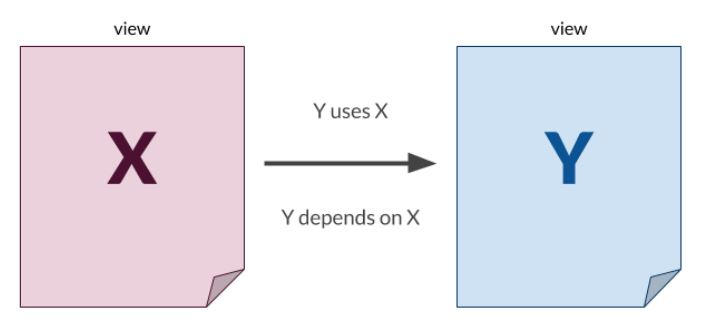

In [6]:
## Dependency example
## Y uses X in the query so Y depends on X
## If Y refreshes before X' refresh completed then Y now is non-updated

#### Managing dependencies
> Materialized-views often depends on other `mv`

> Create a **dependency chain** when refreshing view.

> Not the most efficient to refresh all views at the same time.

> **Tools:** (1) Use `Directed Acylic Graphs (DAGs)` to keep track of view. (2) Pipeline scheduler tools.

### EXERCISEs

#### Exercise 3.1. Materialized versus non-materialized
Materialized and non-materialized are two distinct categories of views. In this exercise, you will organize their differences and similarities.

**SOLUTION.**

| **Non-Materialized views** | **Materialized & Non-Materialized views** | **Materialized views** |
|--|---|--|
| Better to use on write intensive-database | Helps reduce the overhead of writing queries | Store the query result on disk |
| Always return up-to-date data | Can be used in `data-warehouse` | Consumes more storage |

#### Exercise 3.2 Creating and refreshing a materialized view
The syntax for creating materialized and non-materialized views are quite similar because they are both defined by a query. One key difference is that we can refresh materialized views, while no such concept exists for non-materialized views. It's important to know how to refresh a materialized view, otherwise the view will remain a snapshot of the time the view was created.

In this exercise, you will create a materialized view from the table `genres`. 

reviewid|genre
--------|-----
22703|electronic
22721|metal
22659|rock
22661|rock

A new record will then be inserted into genres. To make sure the view has the latest data, it will have to be refreshed.

#### Instructions
Create a materialized view called `genre_count` that holds the number of `reviews` for each `genre`.

Refresh `genre_count` so that the view is `up-to-date`.

**SOLUTION.**

        -- Create a materialized view called genre_count 
        CREATE MATERIALIZED VIEW genre_count AS
        SELECT genre, COUNT(*) 
        FROM genres
        GROUP BY genre;

        INSERT INTO genres
        VALUES (50000, 'classical');

        -- Refresh genre_count
        REFRESH MATERIALIZED VIEW genre_count;

        SELECT * FROM genre_count;
**result.**

genre|count
-----|----
global|217
experimental|1815
metal|860
null|2367
classical|1
electronic|3874
folk/country|685
pop/r&b|1432
jazz|435
rap|1559
rock|9436

If we didn't include that **`REFRESH`** `statement`, the `genre_count` would not have a row for the classical `genre` since that `genre` did not exist before our **`INSERT`** `statement`.

#### Exercise 3.3. Managing materialized views
Why do companies use pipeline schedulers, such as `Airflow` and `Luigi`, to manage materialized views?

A. To set up a `data warehouse` and make sure tables have the most `up-to-date` data.

B. To refresh `materialized views` with consideration to dependences between views.

C. To convert `non-materialized views` to `materialized views`.

D. To prevent the creation of new `materialized views` when there are too many dependencies.

**Answers & comment!**

*A. Wrong!!* Although schedulers can be used to integrate new data into the database, this answer isn't relevant to managing materialized views.

**B. Correct!!!** These pipeline schedulers help visualize dependencies and create a logical order for refreshing views.

*C. Incorrect!!* Although you may technically do that with a scheduler, this is a task that does not need to be scheduled regularly.

*D. Wrong!!* There will naturally be a lot of dependencies between materialized views and it is not always the case that we want to prevent more dependencies.